In [101]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score

In [2]:
zoneDict = pd.read_csv('../processedData/ZonetoComm24.csv')
# del zoneDict['Unnamed: 0']
zoneDict = zoneDict.rename(columns={'start_id':'DOLocationID'})
zoneDict

DOLocationID  start_community
0               1              0.0
1               2              4.2
2               3              2.1
3               4              0.2
4               5              5.1
..            ...              ...
258           259              2.1
259           260              4.3
260           261              0.2
261           262              3.0
262           263              3.0

[263 rows x 2 columns]

In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['start_community'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
hub= 'JFK'
method = 'PCA6'

In [5]:
def ResidinAnomaly(hub,method):
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()



    resid_anomaly_rate = np.log((label_anomaly_value+1)/(prediction_anomaly_value+1))
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date','Type','Name'],var_name='DOLocationID',value_name='resid')
    
    resid_normal_rate = np.log((label_normal_value+1)/(prediction_normal_value+1))
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])

    return (resid_anomaly_rate, resid_normal_rate)

In [6]:
resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method)

In [7]:
zones = gpd.read_file('../Data/NYC Taxi Zones.geojson')
zones['location_id'] = zones['location_id'].astype(int)
zones = zones.merge(zoneDict,left_on='location_id',right_on='DOLocationID')
zones = zones.dissolve(by = 'start_community').reset_index()
zones = zones[['start_community', 'geometry']]
zones['start_community'] = 'zone' + zones['start_community'].astype(str)


In [8]:
zones.to_file('Comm24Map.geojson',driver='GeoJSON')

In [9]:
resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)
resid_anomaly_rate.to_csv('ResidAnomalyMap.csv',index=False)

In [10]:
zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID').to_file('ResidAnomalyMap.geojson',driver='GeoJSON')

In [11]:
resid_normal_rate.index = 'zone' + resid_normal_rate.index.astype(str)
zones.merge(resid_normal_rate,
            left_on='start_community',right_index=True).to_file('ResidNormalMap.geojson',driver='GeoJSON')

In [12]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events

Type                         Name        Date
0   National Holiday               New Year's Day  2018-01-01
1    Extreme Weather                     Blizzard  2018-01-04
2    Extreme Weather                     Blizzard  2018-01-05
3      Airport Event                  Major Delay  2018-01-06
4   National Holiday  Martin Luther King, Jr. Day  2018-01-15
5   National Holiday        Washington's Birthday  2018-02-19
6    Extreme Weather                   Snow Storm  2018-03-21
7    Extreme Weather                   Snow Storm  2018-03-22
8    Extreme Weather                 Thunderstorm  2018-05-15
9   National Holiday                 Memorial Day  2018-05-28
10  National Holiday             Independence Day  2018-07-04
11     Airport Event                  Major Delay  2018-07-23
12  National Holiday                   Labour Day  2018-09-03
13  National Holiday                 Columbus Day  2018-10-08
14  National Holiday                Veteran's Day  2018-11-12
15   Extreme Weather                        Storm  2018-11-15
16  National Holiday                 Thanksgiving  2018-11-22
17  National Holiday                Christmas Day  2018-12-24
18  National Holiday                Christmas Day  2018-12-25
19  National Holiday                 New Year Eve  2018-12-31

In [13]:
resid_anomaly_rate_map = zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID')
resid_anomaly_rate_map.head()

start_community                                           geometry  \
0         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
1         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
2         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
3         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   
4         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...   

         Date              Type                         Name DOLocationID  \
0  2018-01-01  National Holiday               New Year's Day      zone0.0   
1  2018-01-04   Extreme Weather                     Blizzard      zone0.0   
2  2018-01-05   Extreme Weather                     Blizzard      zone0.0   
3  2018-01-06     Airport Event                  Major Delay      zone0.0   
4  2018-01-15  National Holiday  Martin Luther King, Jr. Day      zone0.0   

      resid  
0 -0.218482  
1 -0.127553  
2 -0.184518  
3  0.168050  
4 -0.017457

<Figure size 432x288 with 0 Axes>

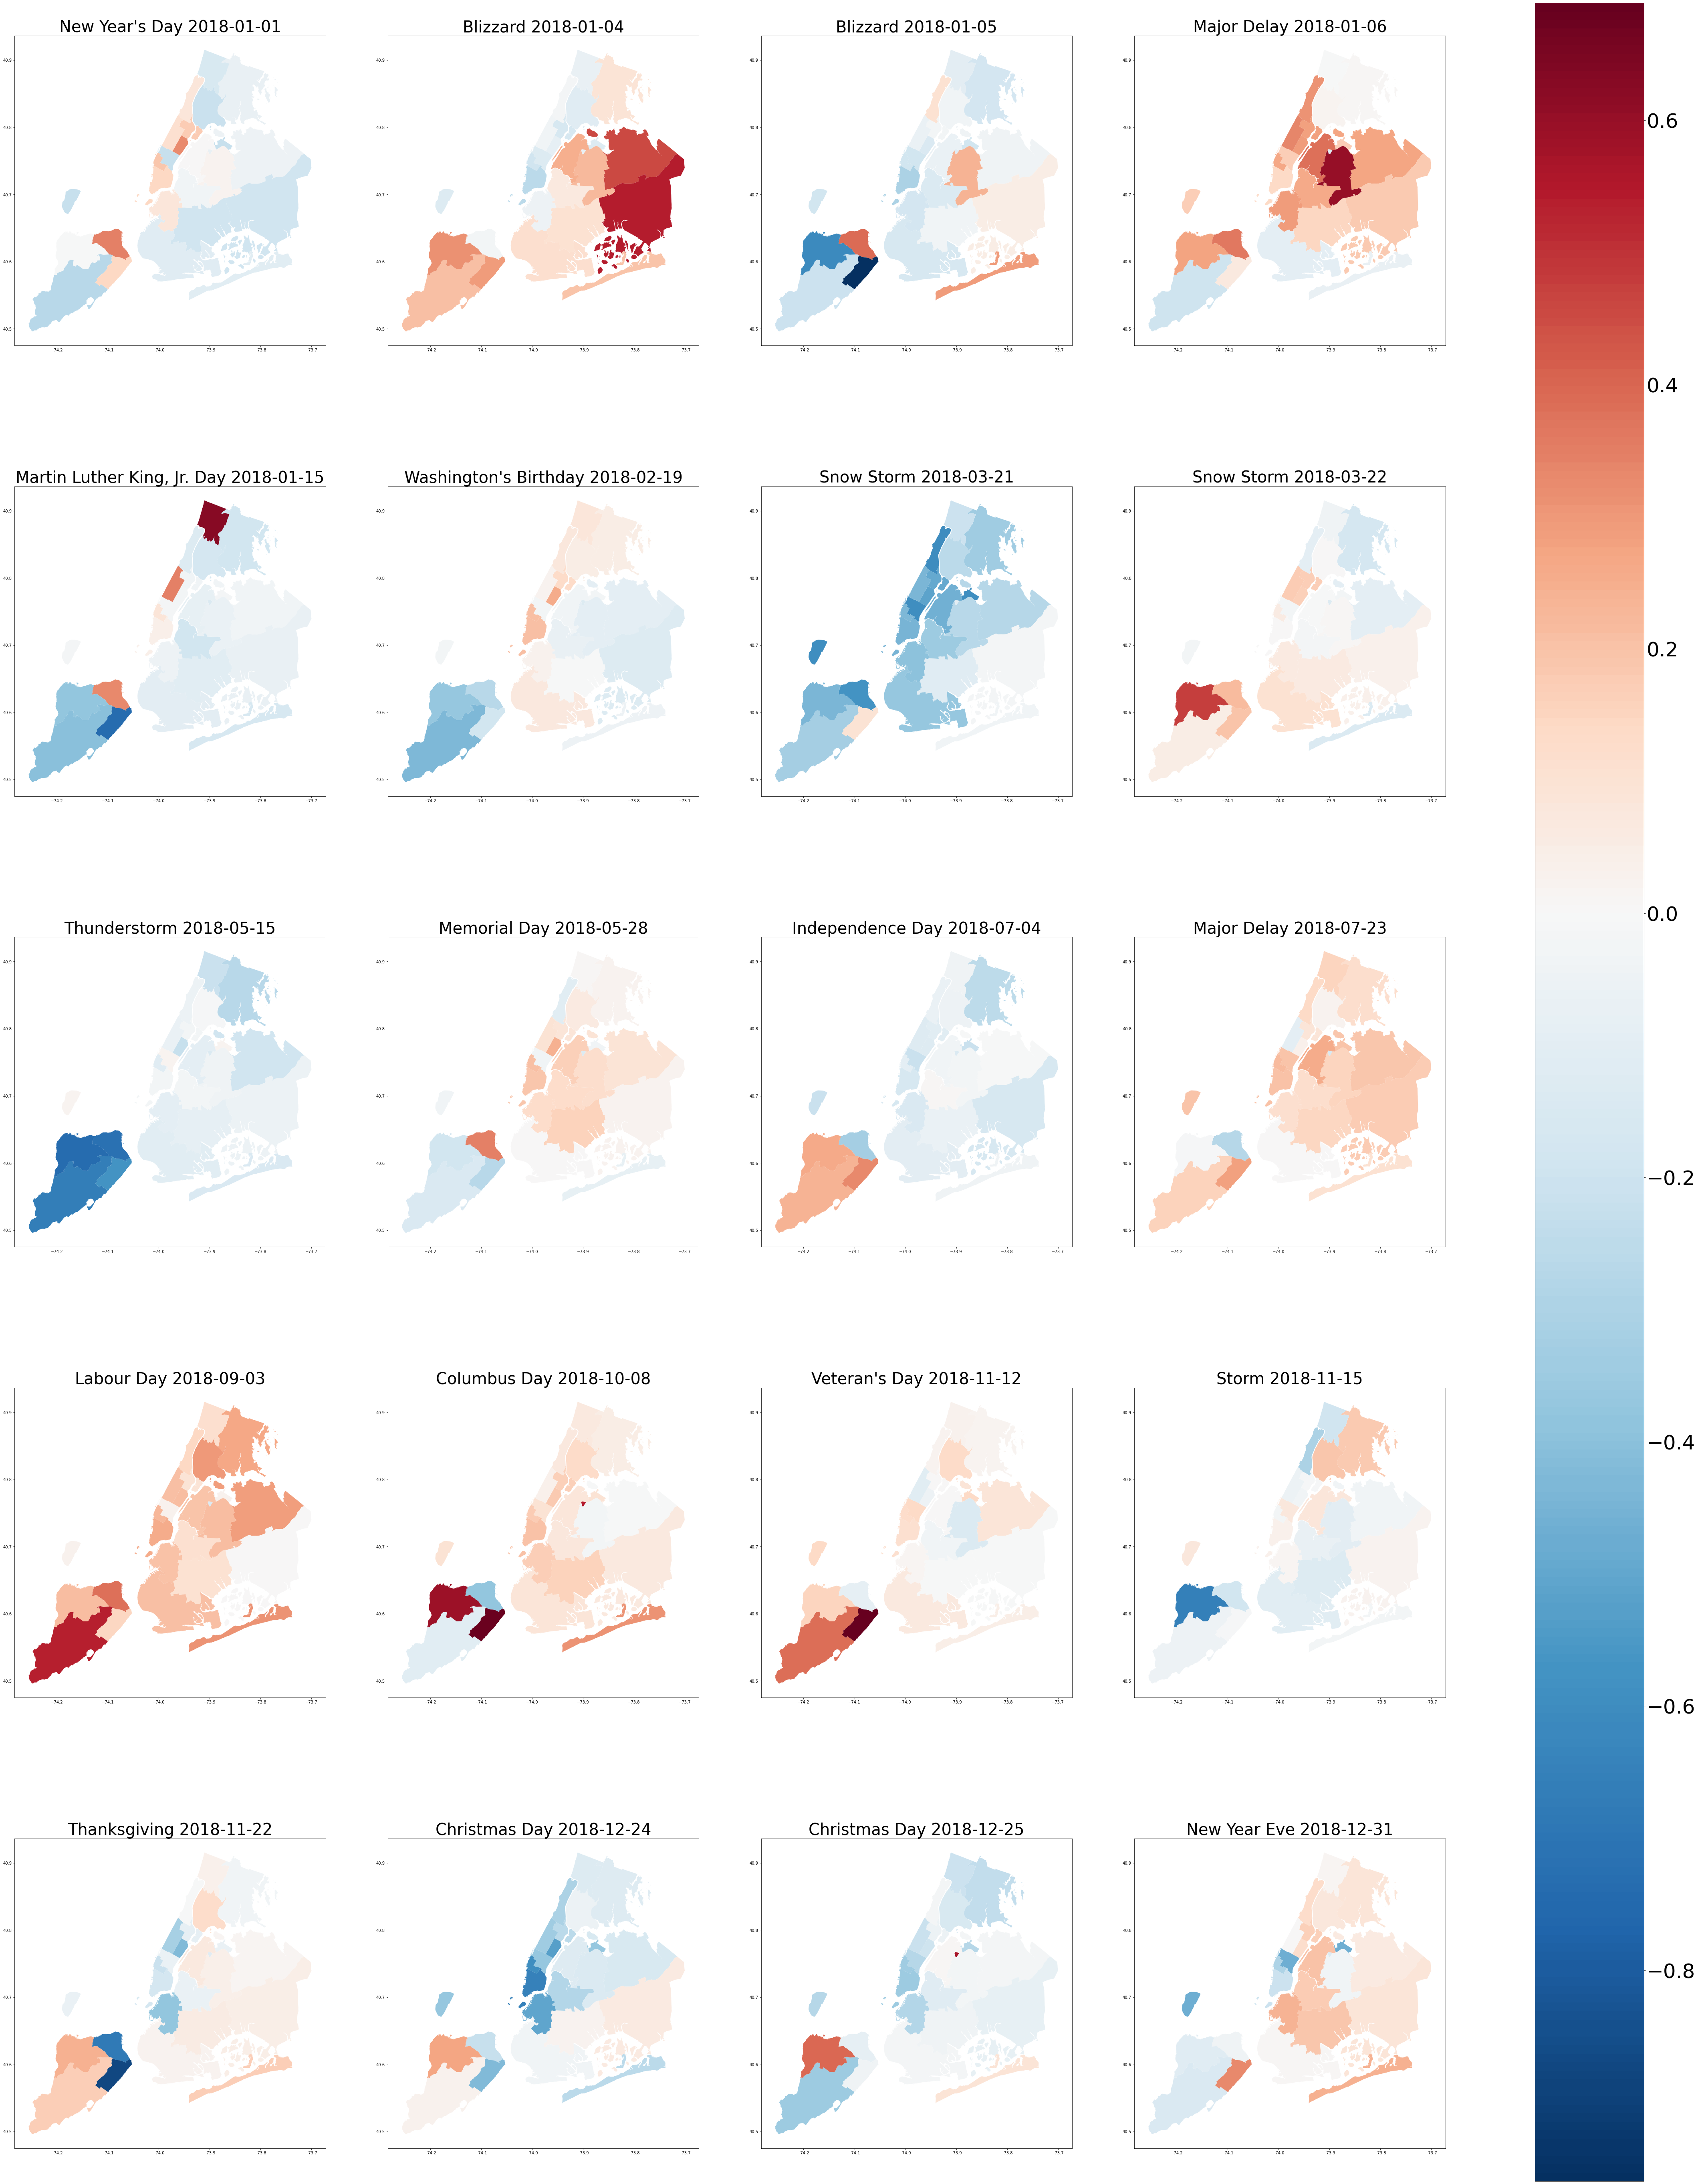

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(5, 4, figsize=(80, 100))
for ind, date in enumerate(events.Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/4),ind%4])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/4),ind%4].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


In [15]:
fig.savefig('ResidulSpatialCluster.jpg',dpi=150,bbox_inches='tight')

In [16]:
resid_normal_rate_map = zones.merge(resid_normal_rate,
            left_on='start_community',right_index=True)





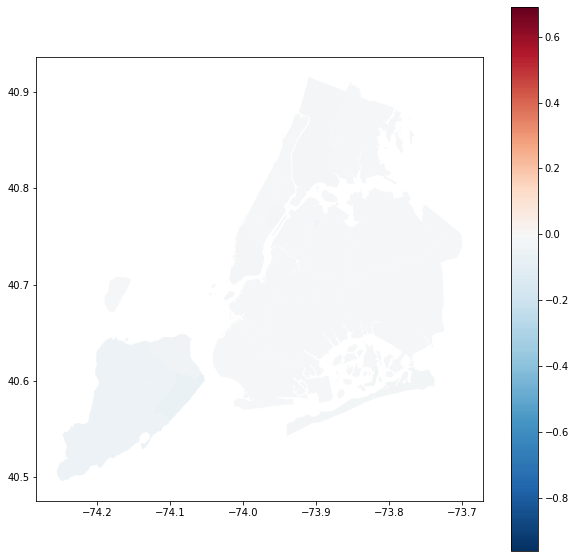

In [17]:
vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
resid_normal_rate_map.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax)
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=10)

In [18]:
df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
X = df.values

In [19]:
def GMMBIC(matrix):

    bic = []
    for ncomp in range(2,6):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [20]:
GMMBIC(X)

GMM in 2 component has the lowest BIC value


2

In [21]:
gm=GaussianMixture(n_components=2,n_init=100,max_iter=1000,random_state=0)
labels = gm.fit_predict(X)

In [22]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events['label'] = labels

In [23]:
events.loc[events['label']==1]

Type                         Name        Date  label
0   National Holiday               New Year's Day  2018-01-01      1
2    Extreme Weather                     Blizzard  2018-01-05      1
3      Airport Event                  Major Delay  2018-01-06      1
4   National Holiday  Martin Luther King, Jr. Day  2018-01-15      1
5   National Holiday        Washington's Birthday  2018-02-19      1
8    Extreme Weather                 Thunderstorm  2018-05-15      1
9   National Holiday                 Memorial Day  2018-05-28      1
11     Airport Event                  Major Delay  2018-07-23      1
12  National Holiday                   Labour Day  2018-09-03      1
15   Extreme Weather                        Storm  2018-11-15      1

<Figure size 432x288 with 0 Axes>

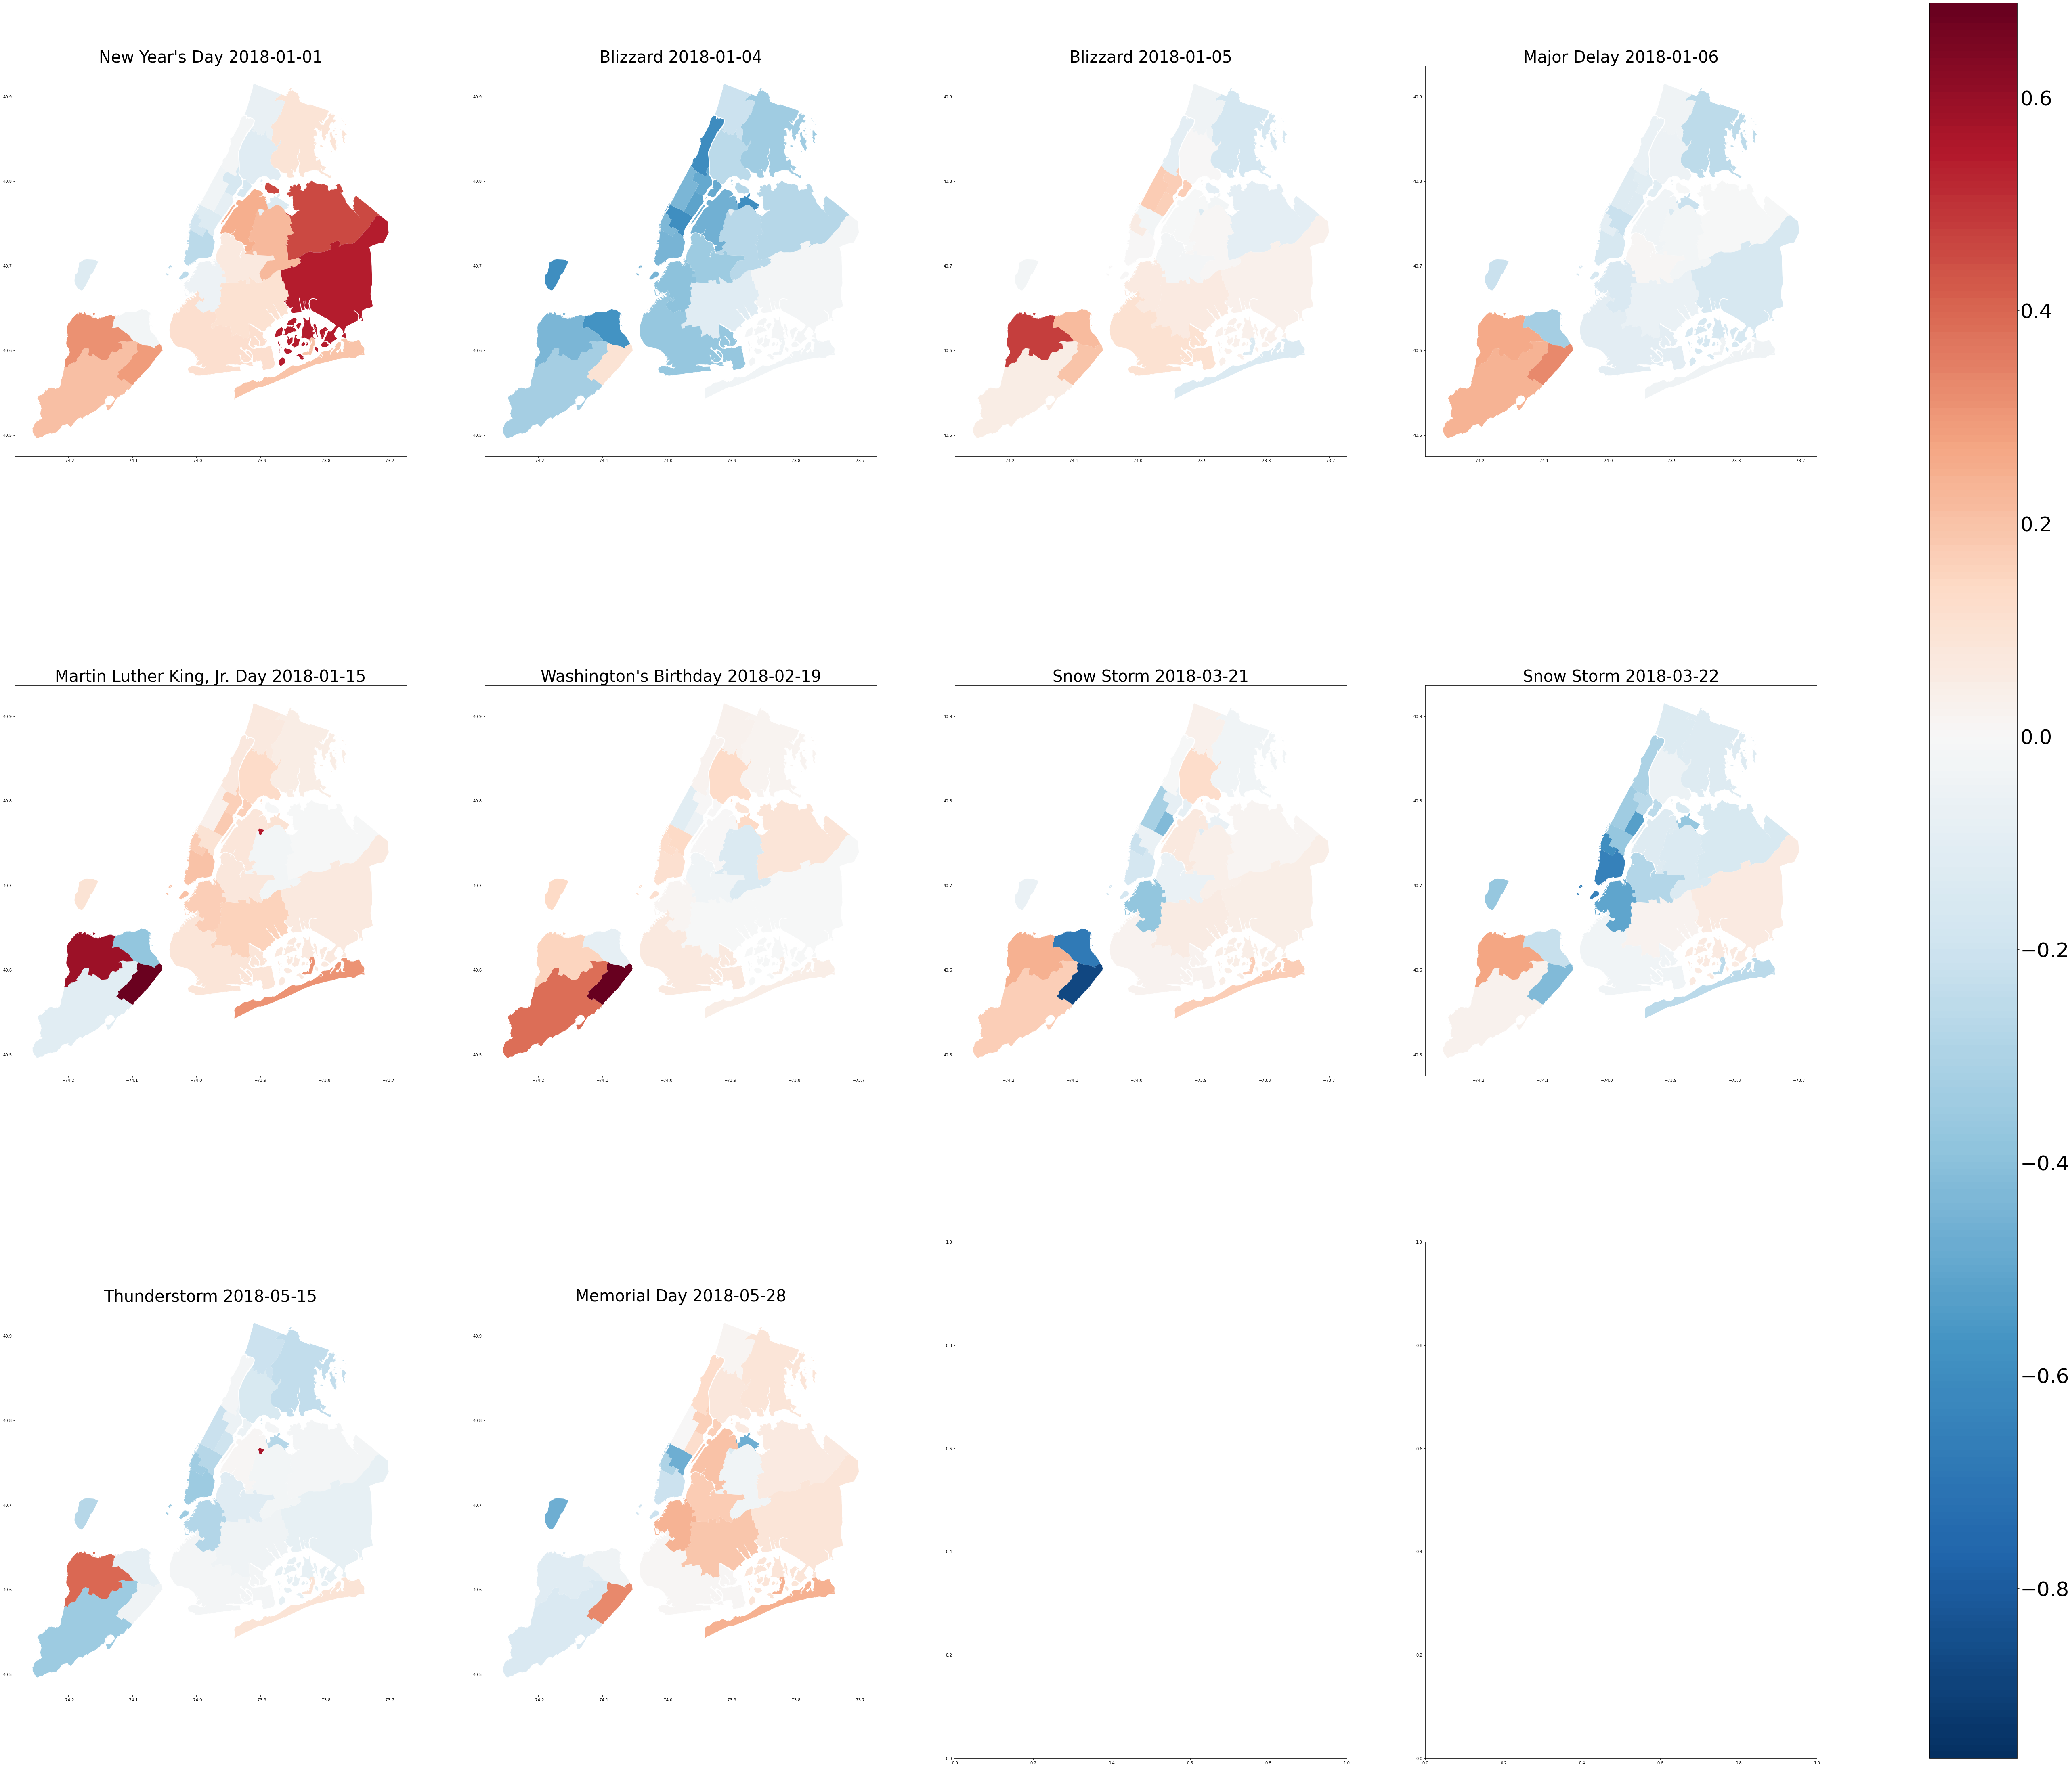

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(3, 4, figsize=(100, 80))
for ind, date in enumerate(events.loc[events['label']==0].Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/4),ind%4])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/4),ind%4].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


<Figure size 432x288 with 0 Axes>

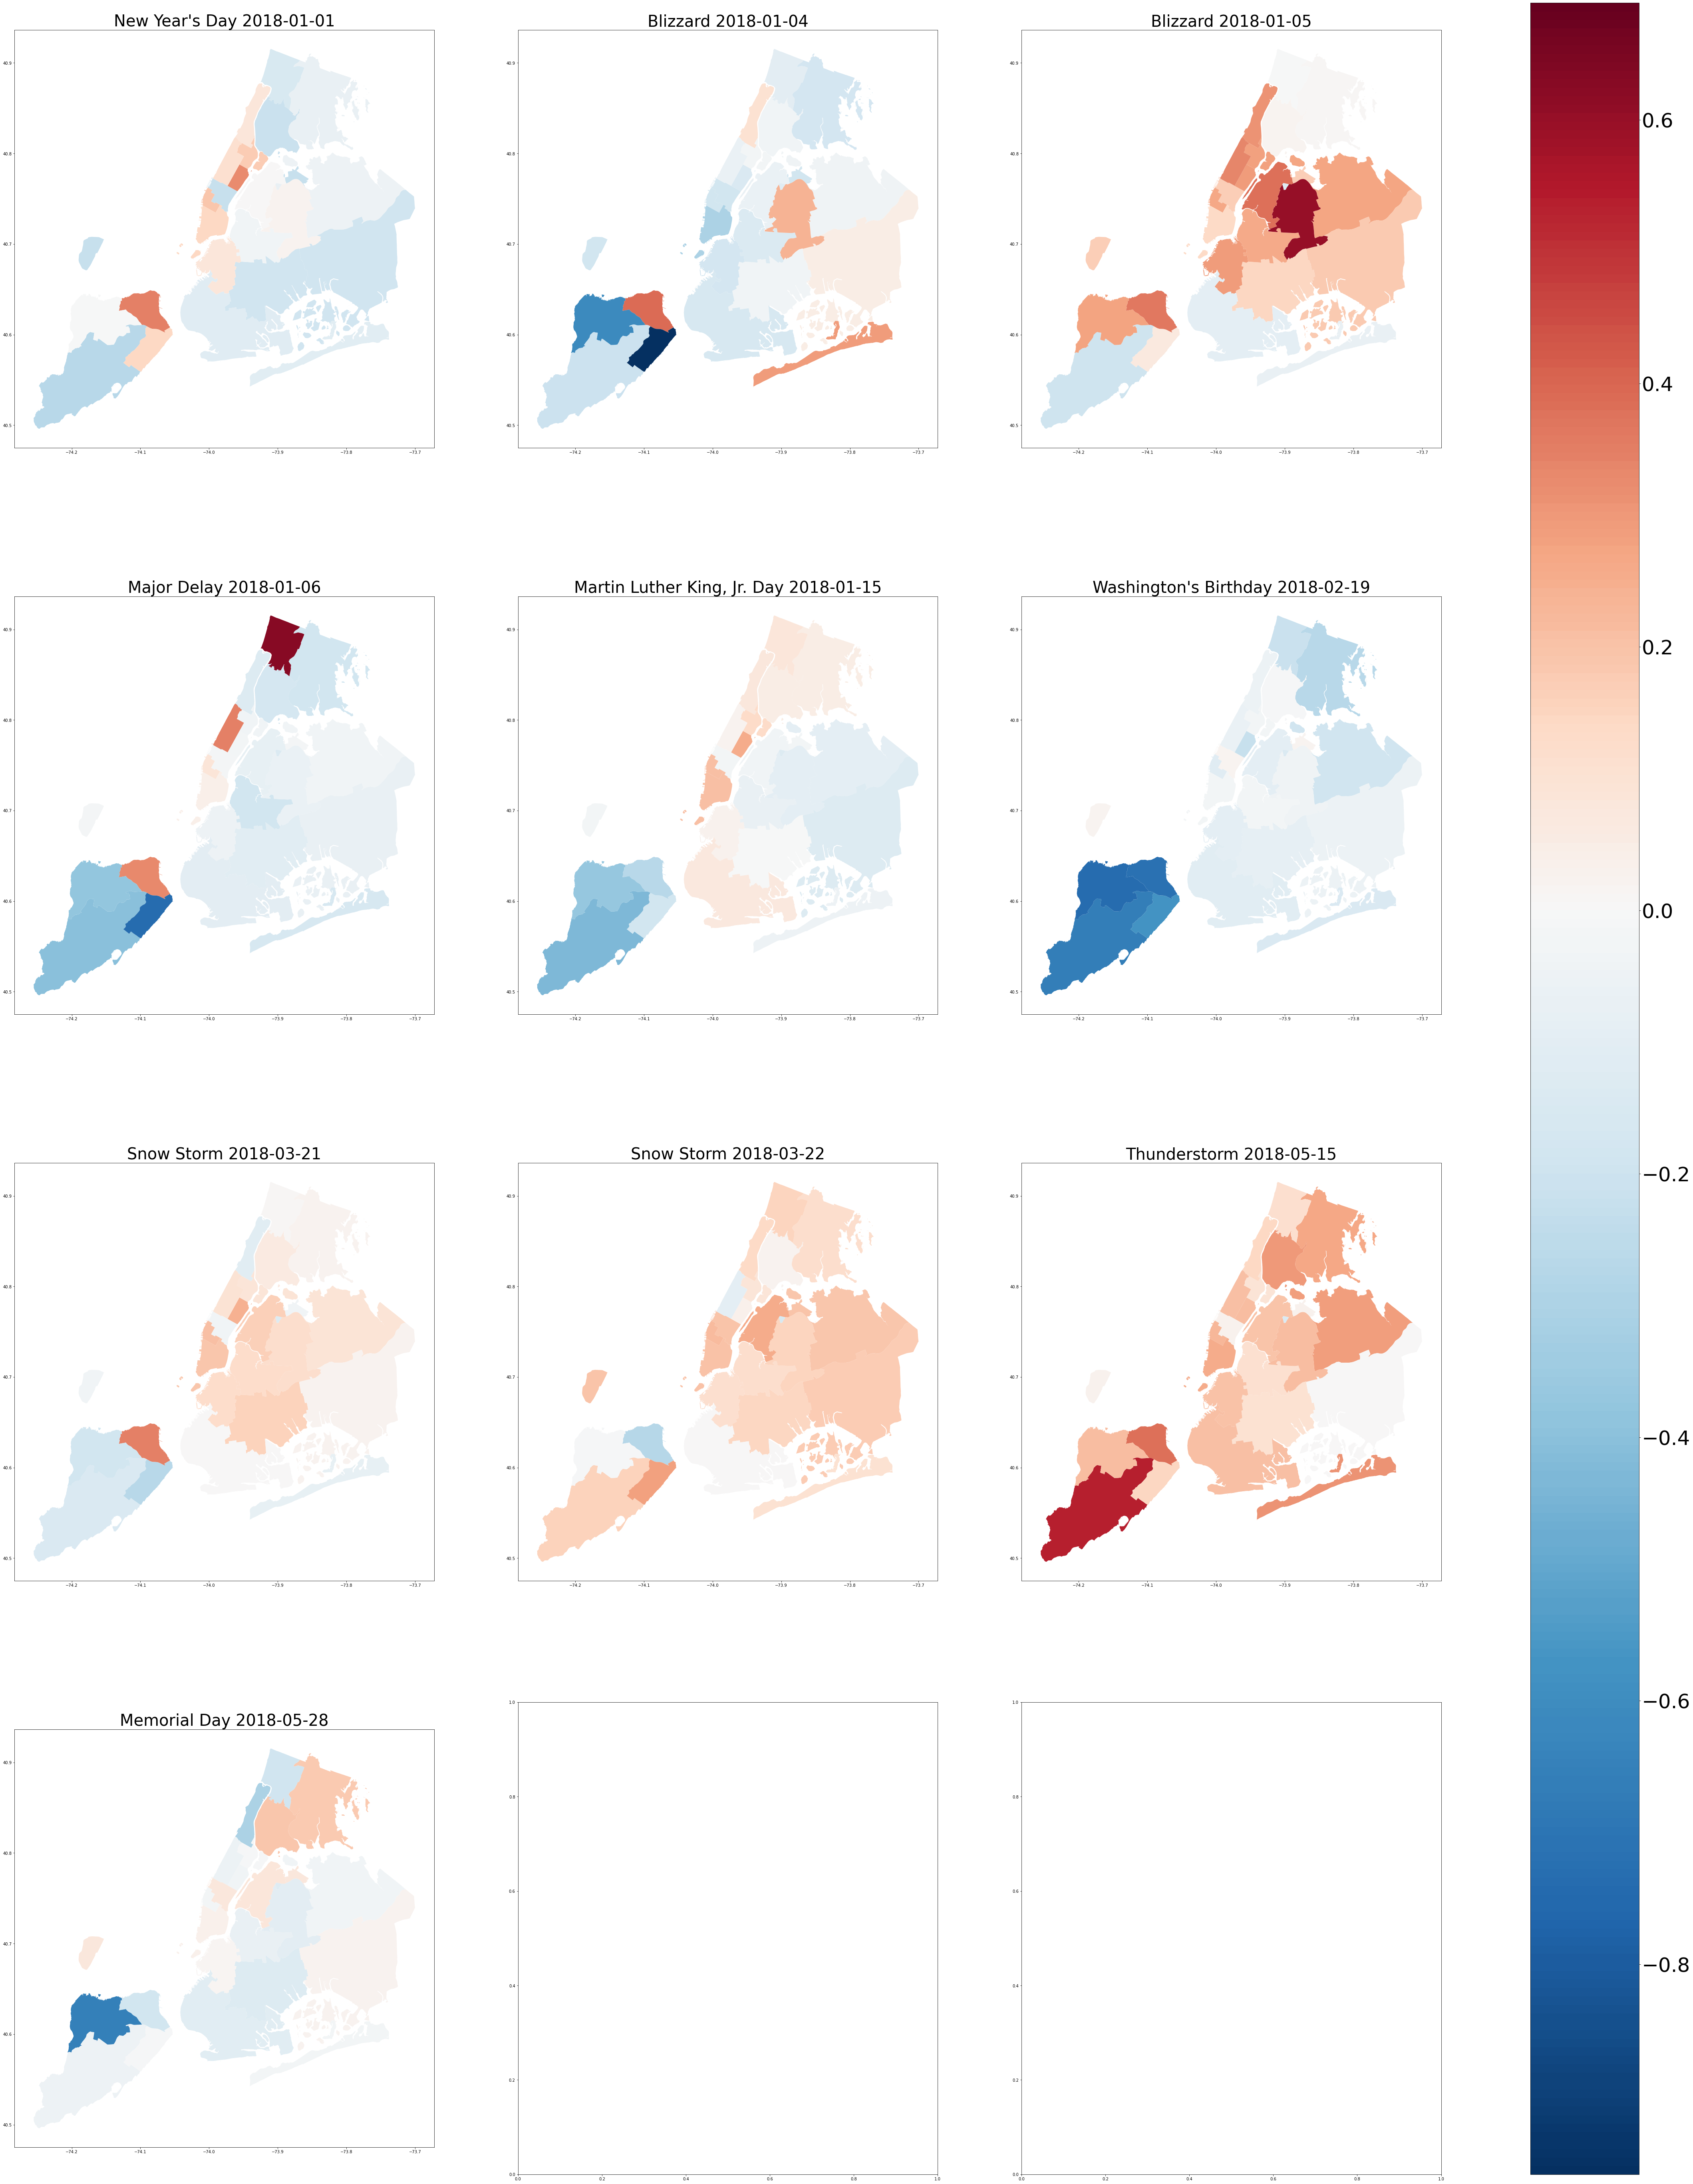

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()
fig,ax = plt.subplots(4, 3, figsize=(80, 100))
for ind, date in enumerate(events.loc[events['label']==1].Date):
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['Date']==date]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[int(ind/3),ind%3])

#     if ind%4 == 0:
#         fig.colorbar(cbar,ax = ax[int(ind/4),ind%4])

    ax[int(ind/3),ind%3].set_title(events.Name[ind]+' '+events.Date[ind], fontsize=40)
    
cb = fig.colorbar(cbar, ax=ax)
cb.ax.tick_params(labelsize=50)


In [26]:
df = df.droplevel(0, axis=1)
df['label'] = labels

In [27]:
df

DOLocationID   zone0.0   zone0.1   zone0.2   zone1.0   zone1.1   zone1.2  \
Date                                                                       
2018-01-01   -0.218482  0.191940  0.144941 -0.193391  0.081002 -0.119555   
2018-01-04   -0.127553 -0.188090 -0.255575  0.106726 -0.048243  0.114275   
2018-01-05   -0.184518 -0.183950 -0.307228 -0.031529 -0.175253 -0.157439   
2018-01-06    0.168050  0.266609  0.138633  0.149787  0.295169 -0.090633   
2018-01-15   -0.017457  0.089213  0.040856 -0.106349 -0.049826 -0.100206   
2018-02-19   -0.023890  0.209595  0.207797 -0.006677  0.026960  0.071266   
2018-03-21   -0.594597 -0.433568 -0.444842 -0.114685 -0.396449 -0.368686   
2018-03-22   -0.023703  0.054950  0.002785  0.061071  0.063846  0.104580   
2018-05-15    0.016596 -0.116751 -0.024405 -0.086405 -0.095204 -0.111256   
2018-05-28   -0.032426  0.204832  0.191856  0.160624  0.126148  0.000264   
2018-07-04   -0.210048 -0.097263 -0.159331 -0.066178 -0.149545 -0.102728   
2018-07-23    0.194955  0.215622  0.203206  0.146541  0.113255  0.003188   
2018-09-03    0.027386  0.227311  0.255976  0.104869  0.202785  0.209134   
2018-10-08    0.100960  0.175664  0.200932  0.158683  0.171933  0.091156   
2018-11-12    0.135027  0.124020  0.108945 -0.001743  0.013912  0.069021   
2018-11-15    0.078807 -0.022865  0.036583 -0.130166  0.014615 -0.108224   
2018-11-22   -0.066971 -0.214603 -0.167819  0.056307 -0.378569  0.024082   
2018-12-24   -0.374670 -0.595879 -0.649979  0.023840 -0.508770 -0.033771   
2018-12-25   -0.271011 -0.340882 -0.347931 -0.038507 -0.278657 -0.019860   
2018-12-31   -0.470559 -0.292441 -0.204108  0.188576  0.240020  0.007432   

DOLocationID   zone1.3   zone2.0   zone2.1   zone2.2  ...   zone4.1   zone4.2  \
Date                                                  ...                       
2018-01-01   -0.032734 -0.216553 -0.067639  0.083055  ... -0.050316 -0.190294   
2018-01-04    0.068773 -0.112807  0.095946 -0.020679  ...  0.455627  0.538880   
2018-01-05   -0.141241 -0.031427 -0.176532  0.105528  ... -0.043363  0.048910   
2018-01-06    0.261289  0.021147  0.005980  0.309236  ...  0.270674  0.177646   
2018-01-15   -0.186111 -0.168986 -0.181261 -0.134545  ... -0.034131 -0.068661   
2018-02-19   -0.070530  0.048632  0.052994  0.079246  ... -0.095377 -0.128029   
2018-03-21   -0.350298 -0.257361 -0.340580 -0.605891  ... -0.270534 -0.017376   
2018-03-22   -0.022075  0.002468 -0.165052 -0.091981  ... -0.095853  0.035131   
2018-05-15   -0.024056 -0.010565 -0.268499 -0.057660  ... -0.188860 -0.054138   
2018-05-28    0.125615  0.063428  0.023372 -0.110701  ...  0.093102  0.022557   
2018-07-04    0.009214 -0.049909 -0.251745 -0.065234  ... -0.004957 -0.159761   
2018-07-23    0.121658  0.024454  0.120335  0.138759  ...  0.190697  0.175792   
2018-09-03    0.109407  0.298703  0.264902  0.140821  ...  0.287325  0.005124   
2018-10-08    0.077195  0.129756  0.049343  0.072769  ... -0.005623  0.066691   
2018-11-12   -0.036681  0.131424  0.020282  0.023241  ...  0.087646 -0.003393   
2018-11-15   -0.073274  0.190037  0.182564 -0.300180  ... -0.034514  0.024609   
2018-11-22   -0.060764  0.124725 -0.034332 -0.003269  ...  0.012956  0.046854   
2018-12-24   -0.284833 -0.057750 -0.122381 -0.306605  ... -0.152248  0.062231   
2018-12-25   -0.113732 -0.150661 -0.233959 -0.016323  ... -0.017611 -0.077440   
2018-12-31    0.175856  0.075937  0.087339  0.128840  ...  0.060827  0.088041   

DOLocationID   zone4.3   zone4.4   zone4.5   zone5.0   zone5.1   zone5.2  \
Date                                                                       
2018-01-01    0.025124 -0.107730  0.003066  0.346236 -0.264967 -0.003433   
2018-01-04    0.221361  0.194830  0.251982 -0.024735  0.209838  0.312535   
2018-01-05    0.238938  0.291820 -0.066381  0.391578 -0.204175 -0.611491   
2018-01-06    0.602538 -0.072355  0.379989  0.361929 -0.196729  0.279042   
2018-01-15   -0.065574 -0.162072 -0.082184  0.330616 -0.399327 -0.376832   
2018-02-19  

In [28]:
df.groupby(['label']).sum()

DOLocationID   zone0.0   zone0.1   zone0.2   zone1.0   zone1.1   zone1.2  \
label                                                                      
0            -1.903125 -1.808090 -1.916924  0.374090 -1.270521 -0.114498   
1             0.009021  1.081557  0.888216  0.007304  0.539652 -0.403461   

DOLocationID   zone1.3   zone2.0   zone2.1   zone2.2  ...   zone4.0   zone4.1  \
label                                                 ...                       
0            -0.537345 -0.164178 -0.895139 -0.885132  ...  0.146283  0.070230   
1             0.090023  0.218869 -0.043786  0.253559  ... -1.267214  0.395236   

DOLocationID   zone4.2   zone4.3   zone4.4   zone4.5   zone5.0   zone5.1  \
label                                                                      
0             0.579857 -0.381058  0.592908 -0.001494 -2.191888  0.161229   
1             0.013515  1.054101  0.069285  0.808212  0.714310 -1.662761   

DOLocationID   zone5.2   zone5.3  
label                             
0             2.154685  1.282726  
1            -2.467321 -2.095787  

[2 rows x 24 columns]

In [29]:
zoneresid = df.groupby(['label']).agg('mean').reset_index()
zoneresid = pd.melt(zoneresid,id_vars=['label'],var_name='DOLocationID',value_name='resid')

zoneresidStd = df.groupby(['label']).agg('std').reset_index()
zoneresidStd = pd.melt(zoneresidStd,id_vars=['label'],var_name='DOLocationID',value_name='std')

zoneresid['std'] = zoneresidStd['std']

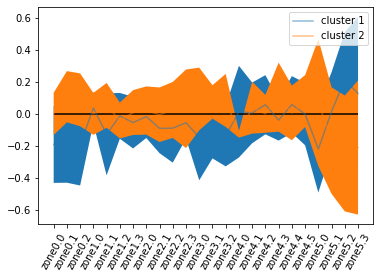

In [31]:

plotdf = zoneresid.loc[zoneresid['label']==0]
_ = plt.plot(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 1')
std = plotdf['std']
plt.fill_between(plotdf['DOLocationID'], plotdf['resid']-std, plotdf['resid']+std)

plotdf = zoneresid.loc[zoneresid['label']==1]
_ = plt.plot(plotdf['DOLocationID'], plotdf['resid'],alpha=0.5,label='cluster 2')
std = plotdf['std']
plt.fill_between(plotdf['DOLocationID'], plotdf['resid']-std, plotdf['resid']+std)
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
_ = plt.xticks(rotation=60)
plt.legend()

In [32]:
resid_anomaly_rate_map = zones.merge(zoneresid.groupby(['label','DOLocationID']).sum().reset_index(),
            left_on='start_community',right_on='DOLocationID')
resid_anomaly_rate_map.head()

start_community                                           geometry  label  \
0         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...      0   
1         zone0.0  MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...      1   
2         zone0.1  POLYGON ((-73.98997 40.73490, -73.98990 40.734...      0   
3         zone0.1  POLYGON ((-73.98997 40.73490, -73.98990 40.734...      1   
4         zone0.2  MULTIPOLYGON (((-74.01395 40.70099, -74.01409 ...      0   

  DOLocationID     resid       std  
0      zone0.0 -0.190313  0.240478  
1      zone0.0  0.000902  0.132155  
2      zone0.1 -0.180809  0.248999  
3      zone0.1  0.108156  0.160189  
4      zone0.2 -0.191692  0.255328

<Figure size 432x288 with 0 Axes>

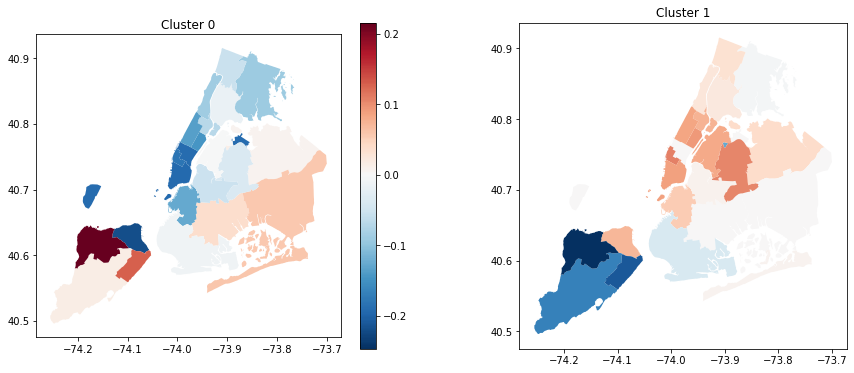

In [33]:

vmin, vmax, vcenter = resid_anomaly_rate_map.resid.min(), resid_anomaly_rate_map.resid.max(), 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'RdBu_r'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

plt.tight_layout()

fig,ax = plt.subplots(1, 2,figsize=(15,6))
plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==0]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[0])
ax[0].set_title('Cluster 0')
plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==1]
plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[1])
ax[1].set_title('Cluster 1')
    
cb = fig.colorbar(cbar, ax=ax[0])
cb.ax.tick_params(labelsize=10)

In [34]:
# residual in all days

path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/RFCV/%sComm24RFCVLogResidDailyAggregated.csv"%hub
resid = pd.read_csv(path)
matrix = resid.drop(columns=['Date']).values

In [35]:
GMMBIC(matrix)

GMM in 2 component has the lowest BIC value


2

In [36]:
path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/GMMIteration/RFCV/%sComm24RFCVLogResidAnomalyDetectionIterationOutput.csv"%hub
iterationDF = pd.read_csv(path)

In [37]:
iterationDF = iterationDF[[col for col in iterationDF.columns if '2-' in col]+['Date']]

In [38]:
iterationDF.columns = [col+'0' if len(col)<6 and col!='Date' else col for col in iterationDF.columns ]

In [39]:
events['Anomaly'] = True
events = events[['Anomaly','Date']].merge(iterationDF[['Date']],on='Date',how='right').fillna(False).sort_values(by='Date')

In [40]:
y_true = events['Anomaly'].values
f1 = {}
for col in iterationDF.columns:
    if col != 'Date':
        y_pred = iterationDF[col].values
        score = f1_score(y_true,y_pred)
        f1[col] = score

In [41]:
def ResidinAnomaly(hub,method,events):
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()



    resid_anomaly_rate = np.log((label_anomaly_value+1)/(prediction_anomaly_value+1))
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date'],var_name='DOLocationID',value_name='resid')
    
    resid_normal_rate = np.log((label_normal_value+1)/(prediction_normal_value+1))
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])

    return (resid_anomaly_rate, resid_normal_rate)

In [55]:
#  5%
def plotinthre(thre):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method,events)
    resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method,events)
    df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
    X = df.values
    comp = 2
#     gm=GaussianMixture(n_components=comp,n_init=100,max_iter=1000,random_state=0)
    labels = gm.predict(X)
    events['label'] = labels
    artificial = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
    resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)
        
    df = df.droplevel(0, axis=1)
    df['label'] = labels
    
    zoneresid = df.groupby(['label']).agg('mean').reset_index()
    zoneresid = pd.melt(zoneresid,id_vars=['label'],var_name='DOLocationID',value_name='resid')

    zoneresidStd = df.groupby(['label']).agg('std').reset_index()
    zoneresidStd = pd.melt(zoneresidStd,id_vars=['label'],var_name='DOLocationID',value_name='std')

    zoneresid['std'] = zoneresidStd['std']
    
    #barplot
    fig,ax = plt.subplots(1,2,figsize=(20,8))
    plotdf = df.loc[df['label']==0]

    _ = ax[0].boxplot(plotdf)
    _ = ax[0].hlines(0, 0,25,color='r')
    _ = plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=70 )
    ax[0].set_title('cluster 1')

    plotdf = df.loc[df['label']==1]
    _ = ax[1].boxplot(plotdf)
    _ = ax[1].hlines(0, 0,25,color='r')
    _ = plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=70 )
    ax[1].set_title('cluster 2')

    zoneresid['DOLocationID'] = 'zone'+zoneresid['DOLocationID']
    resid_anomaly_rate_map = zones.merge(zoneresid.groupby(['label','DOLocationID']).sum().reset_index(),
            left_on='start_community',right_on='DOLocationID')
#     print(zones.head())
#     print(zoneresid.groupby(['label','DOLocationID']).sum().reset_index().head())
    
    vmin, vmax, vcenter = -0.8, 0.8, 0
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = 'RdBu_r'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    plt.tight_layout()

    fig,ax = plt.subplots(1, 2,figsize=(15,6))
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==0]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[0])
    ax[0].set_title('Cluster 1')
    plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==1]
    plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[1])
    ax[1].set_title('Cluster 2')

    cb = fig.colorbar(cbar, ax=ax[0])
    cb.ax.tick_params(labelsize=10)
    resid_anomaly_rate_map = resid_anomaly_rate_map.rename(columns={'resid':'resid%s'%thre})
    del resid_anomaly_rate_map['geometry']
    del resid_anomaly_rate_map['std']
    del resid_anomaly_rate_map['start_community']
    return resid_anomaly_rate_map

In [51]:
# not using confidence interval here because data is skewed

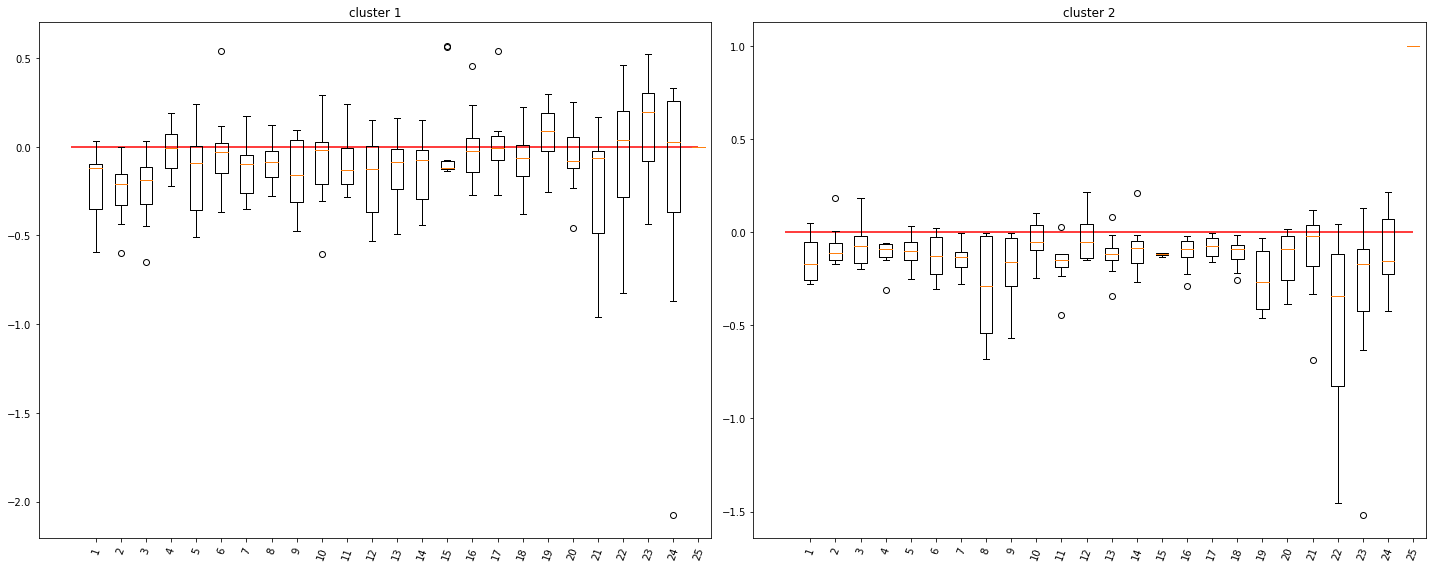

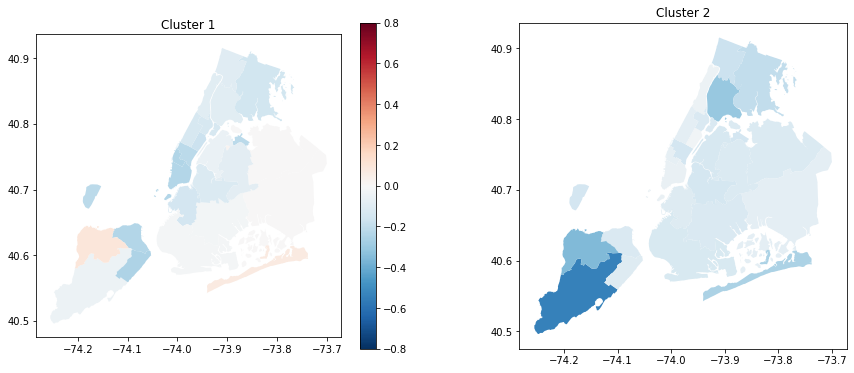

In [131]:
resid_anomaly_rate_map5 = plotinthre(5)

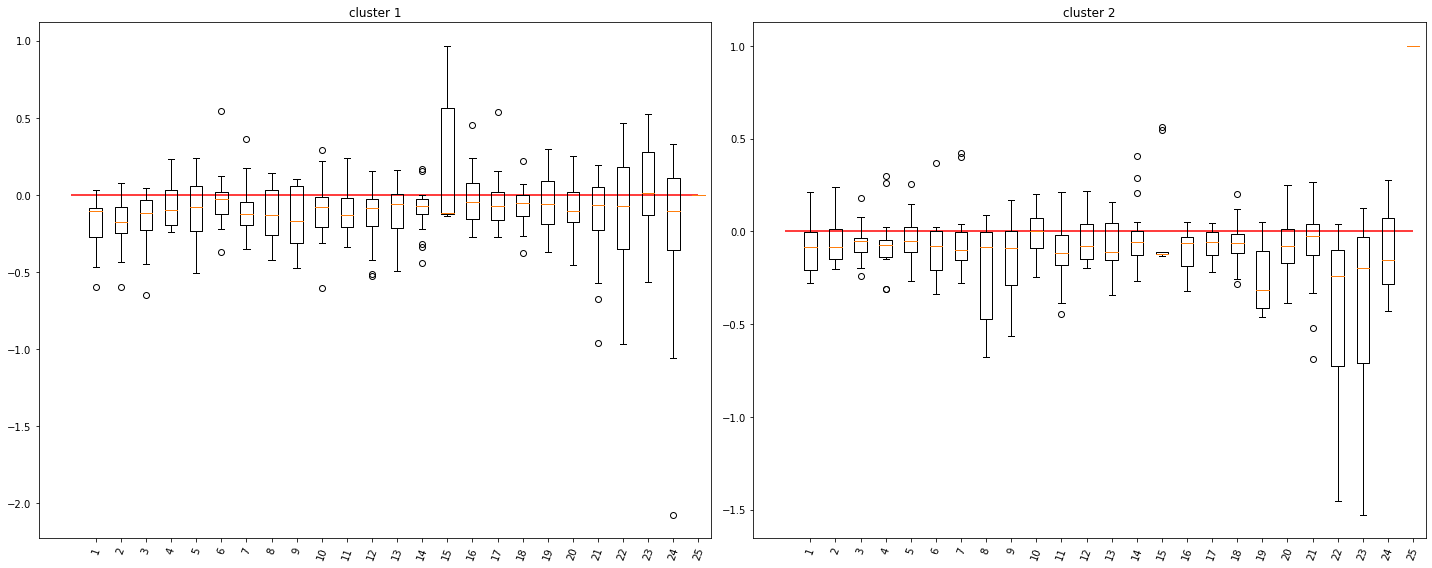

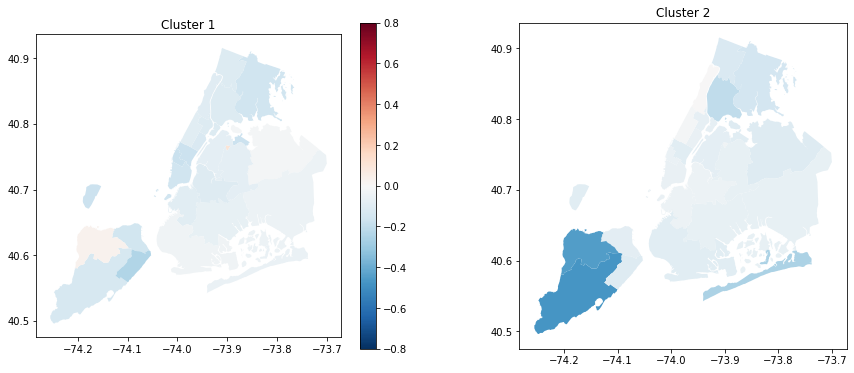

In [58]:
resid_anomaly_rate_map10 = plotinthre(10)

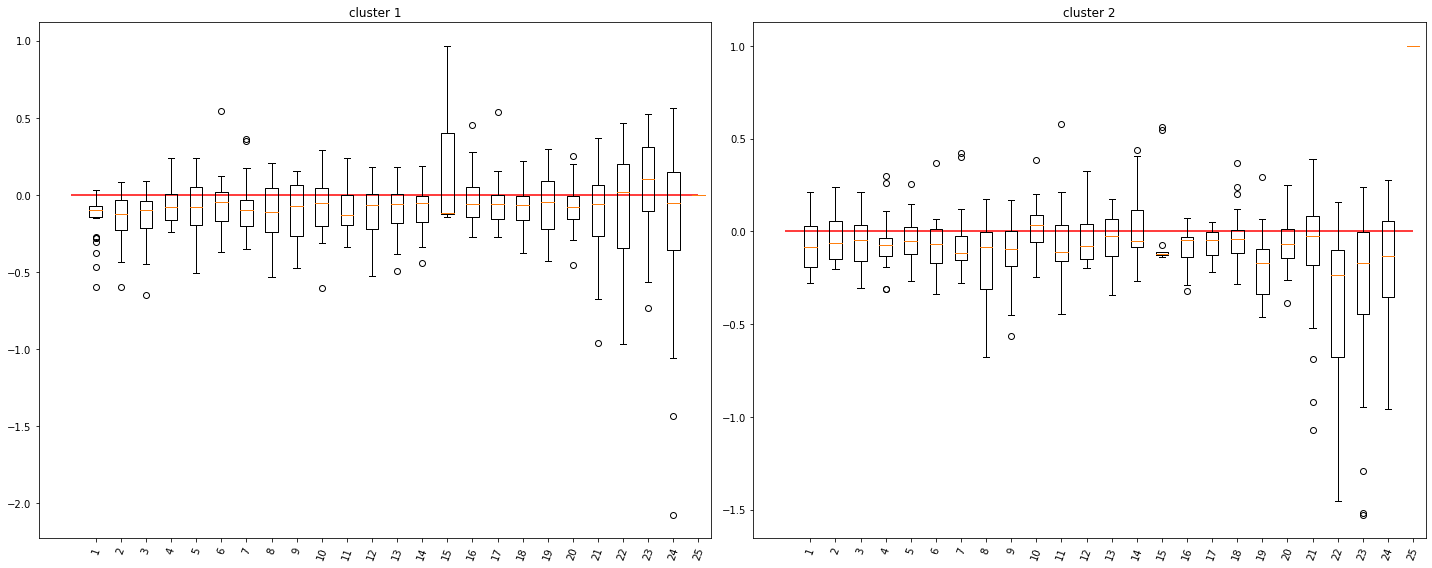

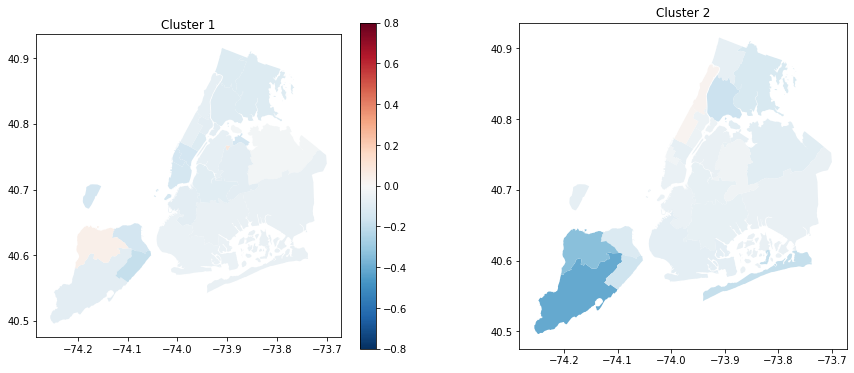

In [59]:
resid_anomaly_rate_map15 = plotinthre(15)

In [64]:
resid = resid_anomaly_rate_map5.merge(resid_anomaly_rate_map10,on=['label','DOLocationID']).merge(resid_anomaly_rate_map15,on=['label','DOLocationID'])
resid.head(2)

label DOLocationID    resid5   resid10   resid15
0      0      zone0.0 -0.217493 -0.169492 -0.145249
1      1      zone0.0 -0.144423 -0.090795 -0.074611

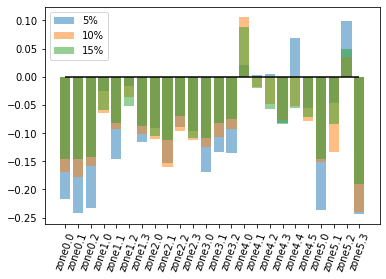

In [79]:
plotdf = resid.loc[resid['label']==0]
_ = plt.bar(plotdf.DOLocationID, plotdf.resid5,alpha=0.5,label='5%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid10,alpha=0.5,label='10%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid15,alpha=0.5,label='15%')
_ = plt.xticks(rotation=70)
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
plt.legend()

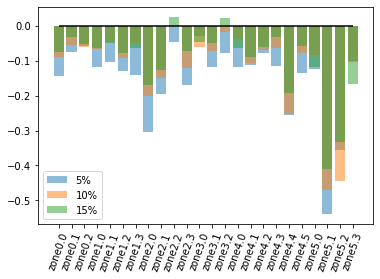

In [80]:
plotdf = resid.loc[resid['label']==1]
_ = plt.bar(plotdf.DOLocationID, plotdf.resid5,alpha=0.5,label='5%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid10,alpha=0.5,label='10%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid15,alpha=0.5,label='15%')
_ = plt.xticks(rotation=70)
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
plt.legend()

In [123]:
def dataPrep(hub,method):
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    
    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    
    label = pd.read_csv('../processedData/'+hub+'VehicleByHour.csv')
    label.columns = [str(col) for col in label.columns]
    label.DOLocationID = label.DOLocationID.astype(str)
    label = label.rename(columns={'vehicle_count':'label'})
    prediction = pd.read_csv('../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction.DOLocationID = prediction.DOLocationID.astype(str)
    prediction = prediction.rename(columns={'vehicle_count':'prediction'})
    df = label.merge(prediction,on=['Date','Hour','DOLocationID'])
    return df
def elbow(df,thre,r2iteration):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    mask = df['Date'].isin(events['Date'])
    df_normal = df[~mask]
    r2 = r2_score(df_normal.label,df_normal.prediction)
    r2iteration[str(thre)] = r2
    return r2iteration


In [124]:
r2iteration = {}
df = dataPrep('JFK','PCA6')
for thre in range(0,100):
    r2iteration = elbow(df,thre,r2iteration)

<AxesSubplot:>

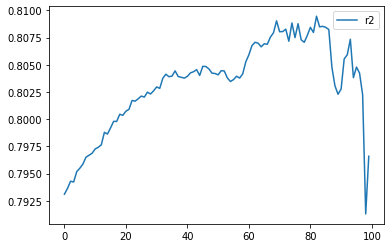

In [125]:
pd.DataFrame(r2iteration.items(), columns=['thre', 'r2']).plot()

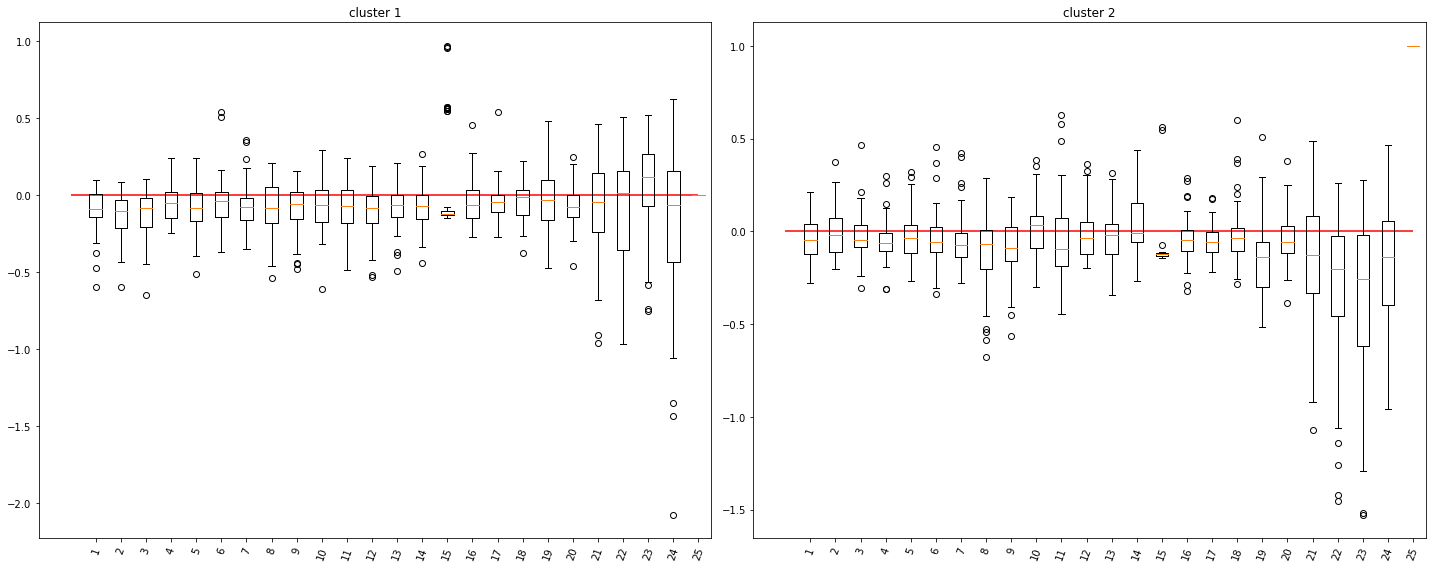

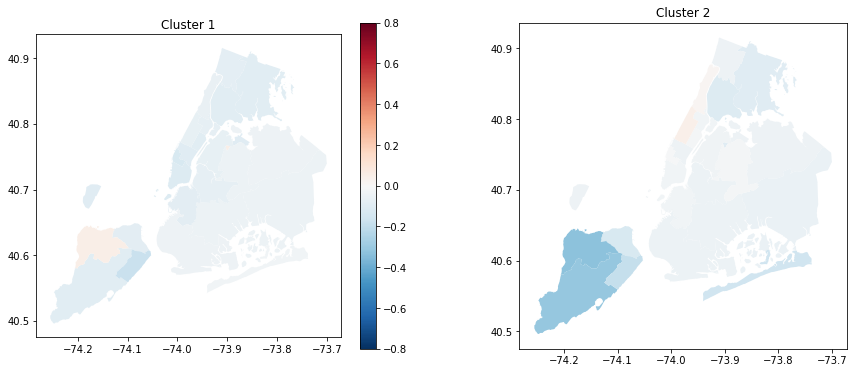

In [130]:
resid_anomaly_rate_map30 = plotinthre(30)

In [132]:
resid = resid_anomaly_rate_map5.merge(resid_anomaly_rate_map10,on=['label','DOLocationID']).\
        merge(resid_anomaly_rate_map15,on=['label','DOLocationID']).\
        merge(resid_anomaly_rate_map30,on=['label','DOLocationID'])

resid.head(2)

label DOLocationID    resid5   resid10   resid15   resid30
0      0      zone0.0 -0.217493 -0.169492 -0.145249 -0.095618
1      1      zone0.0 -0.144423 -0.090795 -0.074611 -0.039803

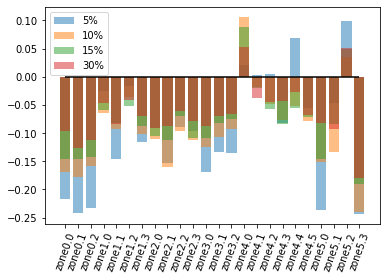

In [133]:
plotdf = resid.loc[resid['label']==0]
_ = plt.bar(plotdf.DOLocationID, plotdf.resid5,alpha=0.5,label='5%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid10,alpha=0.5,label='10%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid15,alpha=0.5,label='15%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid30,alpha=0.5,label='30%')
_ = plt.xticks(rotation=70)
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
plt.legend()

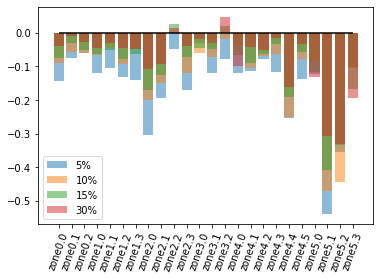

In [134]:
plotdf = resid.loc[resid['label']==1]
_ = plt.bar(plotdf.DOLocationID, plotdf.resid5,alpha=0.5,label='5%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid10,alpha=0.5,label='10%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid15,alpha=0.5,label='15%')
_ = plt.bar(plotdf.DOLocationID, plotdf.resid30,alpha=0.5,label='30%')
_ = plt.xticks(rotation=70)
_ = plt.hlines(0, xmin=plotdf.DOLocationID.values[0],xmax=plotdf.DOLocationID.values[-1],color='k')
plt.legend()